# Full Train Workflow

Run when you need to train a new classifier from scratch. Will regenerate transient data, refit all samples, and retrain the classifier.

## Step 0: Update configuration file.

In the same folder as this notebook, there is a $\texttt{config.yaml}$ file, which contains all filepaths and configuration options for the training workflow. Please update this now!

The most important filepath arguments are:
* $\texttt{create-dirs}$: Probably keep set to True. Create any data subdirectories that are missing.
* $\texttt{data-dir}$: This is where all generated data is stored. Set to the root directory for all outputs.
* $\texttt{relative-dirs}$: If true, all data for each step is stored within subdirectories of data_dir.
* $\texttt{transient-data-fn}$: This is where all transient data is stored as a TransientGroup. Technically a directory but loaded as a single file. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{sampler-results-fn}$: Where light curve fits are stored. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{figs-dir}$: Where all figures are stored (only generated if $\texttt{plot}$ is set to True). If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{models-dir}$: Where all classification models are stored. If relative_dirs is True, is created as a subdirectory of data_dir.

The most important sampling and classifier arguments are:
* $\texttt{sampler}$: Set to either dynesty or svi (all lowercase). SVI is faster but forces the posterior into a multivariate Gaussian.
* $\texttt{model-type}$: Set to either LightGBM (recommended) or MLP.
* $\texttt{use-redshift-features}$: If True, includes peak absolute magnitude and redshift as training features.
* $\texttt{fits-per-majority}$: Oversamples such that the majority class has this many samples fed into the classifier. Minority classes will correspond to more input samples per event. Defaults to 5.
* $\texttt{target-label}$: For binary classification - this is the positive label. Set to None for multiclass classification.
* $\texttt{n-folds}$: Number of K-folds. I usually set to 10.
* $\texttt{num-epochs}$: Number of estimators for LightGBM or number of training epochs for MLP.
* $\texttt{n-parallel}$: Number of threads to parallelize data import + sampling over.
* $\texttt{random-seed}$: For reproducibility.

If you want to use hierarchical classification with the MLP, you need to also manually fill in the following:
* $\texttt{hierarchy}$: Set to True if you want to use the weighted hierarchical loss function (WHXE). Otherwise, make sure this is set to False.
* $\texttt{class-weights}$: Manually import these values using the class_weights.ipynb notebook to calculate the relevant class weights for the (WHXE). If you are not using this, set it to None.
* $\texttt{graph}$: This is a dictionary of properties of the taxonomic graph. Set each element to null if not using the WHXE.
    * $\texttt{edges}$: A list of 2-element lists containing the edges in the taxonomic graph in use. If not using WHXE, set to None.
    * $\texttt{height}$: The height you want the classifier to go to in terms of the taxonomic tree. Set to None if not using WHXE.
    * $\texttt{root}$: The root node of the tree as a string. This is set to None if not using WHXE.
    * $\texttt{vertices}$: A list of all of the vertices within the tree, including those that are not labels within the dataset. Set to None if not using WHXE. 
    * $\texttt{ignored-leaves}$: A list of the leaf vertices within the tree that do not have any counts for them within class_weights or we otherwise want to ignore. Set to None if not using WHXE.   

## Step 1: Generate new TransientSet

Here we will import data from TNS + ALeRCE and generate a new TransientSet, from a list of event names. Names can be from TNS or ZTF.

The below code block will retrieve all spectroscopically classified TNS transients. Feel free to change to your own list of names or import script.

In [1]:
from pathlib import Path
import os
from snapi.query_agents import TNSQueryAgent

p = Path(os.getcwd()).parents[1]
print(p)
#SAVE_DIR = os.path.join(p, "data", "tutorial") # Use this line if you want to use tutorial data.
SAVE_DIR = os.path.join(p, "docs", "notebooks", "whxe_notebooks", "data")
print(SAVE_DIR)

tns_agent = TNSQueryAgent(db_path=SAVE_DIR)
#tns_agent.update_local_database() # IMPORTANT: run this line if first time using SNAPI or if you want to reimport TNS csv
all_names = tns_agent.retrieve_all_names() # only spectroscopically classified
all_names = [x for x in all_names if int(x[:4]) > 2018] # because pre-2019 templates are pretty bad
print(len(all_names), all_names[:5])

/Users/charisgraham/Desktop/Summer2025/superphotplus/superphot-plus
/Users/charisgraham/Desktop/Summer2025/superphotplus/superphot-plus/docs/notebooks/whxe_notebooks/data
15745 ['2025oai', '2025oxy', '2025pao', '2025odd', '2025obd']


The following script will import data for all provided names and generate a TransientGroup object. Will run in parallel across n_cores threads.

For the entire TNS dataset (~16000 events), this takes ~30 minutes on 8 parallel cores.

In [2]:
# First augments the config file to save to your data folder path!
# Feel free to change to any path you want
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
config.update(data_dir=SAVE_DIR)
config.write_to_file('config.yaml')


/opt/miniconda3/envs/superphot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.data_generation import import_all_names

config = SuperphotConfig.from_file("config.yaml")
save_dir = config.transient_data_fn

# import data for all_names from query agents 
# QUALITY CUTS HAPPEN HERE
import_all_names(
    all_names, save_dir,
    checkpoint_freq=100,
    n_cores=config.n_parallel,
    overwrite=False,
    skipped_names_fn = os.path.join(config.data_dir, "skipped_names.txt")
) # set overwrite=False to continue from where left off

In [3]:
# Let's check the TransientGroup we created!
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)

print(len(transient_group.metadata))
print(transient_group.metadata.head())
print(transient_group.metadata.groupby('spec_class').count())

7341
                  ra        dec                     internal_names spec_class  \
id                                                                              
2019J     150.944878   6.773457  ZTF19aacxrab, ATLAS19cay, PS18crs     SLSN-I   
2019aafe  349.068683  48.428444                       ZTF19abzfxel     SN IIn   
2019aamp  219.455292  20.304611                       ZTF19aantokv     SLSN-I   
2019aanx  112.499958  13.095333                       ZTF19ackiwff    SLSN-II   
2019aaot    3.069526  -5.727405                       ZTF19aazdroc        AGN   

          redshift  
id                  
2019J        0.120  
2019aafe     0.074  
2019aamp     0.404  
2019aanx     0.403  
2019aaot     0.283  
                     ra   dec  internal_names  redshift
spec_class                                             
AGN                  39    39              39        39
CV                   84    84              84        51
Galaxy                4     4               4         4


Finally, before fitting, we want to phase and normalize all the photometry. This is because our samplers expect light curves to already be phased and normalized before fitting.

---- REMOVE LATER ----

### STEP 1.5: Hierarchical Counts + Class Weights

If we are using WHXE in an MLP, we need generate a taxonomy to be used in our Weighted Hierachical Cross Entropy Loss function.

We want to use the counts of items following the quality cuts as that is what our model is training on.

##### Substep 1: We want to load in the quality cut data as a CSV file.

In [4]:
from superphot_plus.config import SuperphotConfig
import pandas as pd

config = SuperphotConfig.from_file("config.yaml")
if config.use_hierarchy:
    df = transient_group.metadata
    df.to_csv('./whxe_notebooks/data/quality_cut_tns_data.csv')

##### Substep 2: Adjust Weights, Labels, and Tree

Here we need to adjust a few things:

1. Update the weight dictionary to be based on the data following the quality cuts in **import_all_names** above. 
2. Adjust the tree/taxonomy the user inputted above to desired **height** given in **config.yaml** and develop an updated mapping schema based on the **mapping** schema

##### Task 2.1 Update Weight Dictionary

If you hadn't originally, go back to the **class_weights.ipynb** file and change the loaded in CSV file into the CSV of the file following quality cuts. Rerun this and update the config.yaml file as appropriate.

In [5]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.model.taxonomy import Taxonomy

config = SuperphotConfig.from_file("config.yaml")
print(config.class_weights)

{'SLSN-I': [3.6379310344827585, 87], 'SLSN-II': [7.9125, 40], 'SN': [11.722222222222221, 27], 'SN II': [0.29278445883441256, 1081], 'SN II-pec': [45.214285714285715, 7], 'SN IIP': [3.767857142857143, 84], 'SN IIb': [3.478021978021978, 91], 'SN IIn': [1.6065989847715736, 197], 'SN Ia': [0.06537905391448048, 4841], 'SN Ia-91bg-like': [9.308823529411764, 34], 'SN Ia-CSM': [18.61764705882353, 17], 'SN Ia-SC': [31.65, 10], 'SN Ia-pec': [10.55, 30], 'SN Ib': [2.9305555555555554, 108], 'SN Ib-pec': [63.3, 5], 'SN Ib/c': [14.386363636363637, 22], 'SN Ibn': [12.66, 25], 'SN Ic': [2.47265625, 128], 'SN Ic-BL': [5.188524590163935, 61], 'SN Ic-pec': [316.5, 1], 'SN Icn': [158.25, 2], 'TDE': [4.869230769230769, 65]}


##### Task 2.2 Adjust the Tree & Mapping

We need to define the taxonomy class variable to be used as our tree for processing as well as adjust the tree (and relevant values) to the desired height. This all happens in the backend when defining **taxonomy**. We also want to define the mapping schema for values down the line.

In [6]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.model.taxonomy import Taxonomy

config = SuperphotConfig.from_file("config.yaml")

if config.use_hierarchy:
    taxonomy = Taxonomy(config)
    print(taxonomy)

mapping: {'SN II': 'SN II-like', 'SN Ibn': 'SN Ib-gen', 'SN Ic-BL': 'SN Ic-gen', 'SN IIn': 'SN IIn-like', 'SN Ib': 'SN Ib-gen', 'SN Ic-pec': 'SN Ic-gen', 'SLSN-II': 'SN IIn-like', 'SN Ib-pec': 'SN Ib-gen', 'SN II-pec': 'SN II-like', 'SN Icn': 'SN Ic-gen', 'SN Ic': 'SN Ic-gen', 'SN IIP': 'SN II-like', 'SN IIb': 'SN II-like'}
weight_dict: {'SLSN-I': [6.156498673740053, 87], 'SN': [19.837606837606838, 27], 'SN Ia': [0.11064147585527466, 4841], 'SN Ia-91bg-like': [15.753393665158372, 34], 'SN Ia-CSM': [31.506787330316744, 17], 'SN Ia-SC': [53.56153846153846, 10], 'SN Ia-pec': [17.853846153846153, 30], 'SN Ib/c': [24.346153846153847, 22], 'TDE': [8.240236686390533, 65], 'SN II-like': [0.4240818563858944, 1263], 'SN Ib-gen': [3.8812709030100336, 138], 'SN Ic-gen': [2.7896634615384617, 192], 'SN IIn-like': [2.2599805258033108, 237]}
graph: {'edges': [['SN-like', 'SN-gen'], ['SN-like', 'TDE'], ['SN-gen', 'SN'], ['SN-gen', 'SN Ia-gen'], ['SN-gen', 'CC'], ['SN Ia-gen', 'SN Ia'], ['SN Ia-gen', 'S

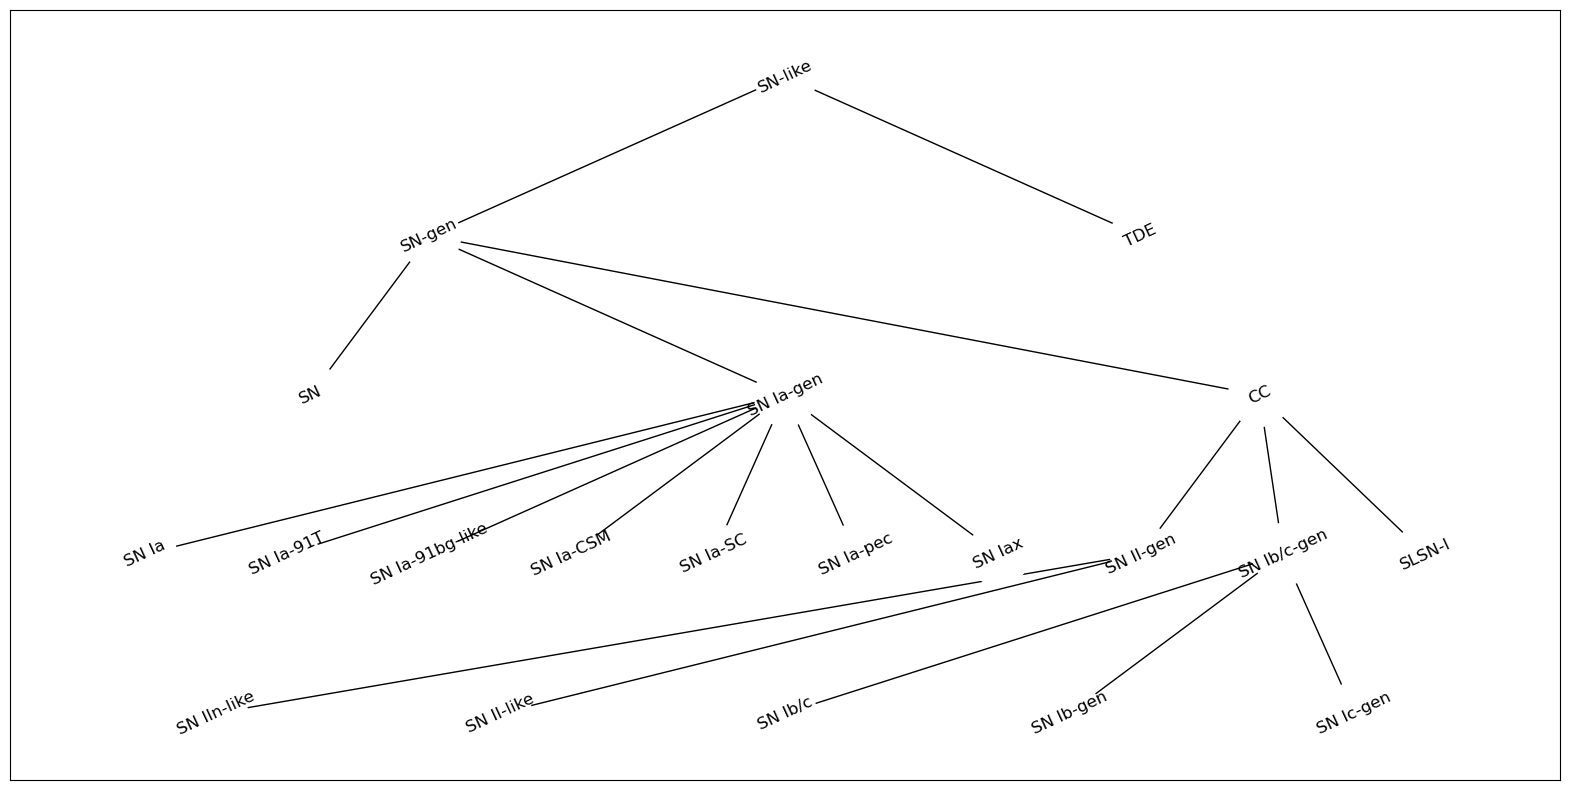

In [8]:
if config.use_hierarchy:    
    taxonomy.draw_graph()

---- REMOVE LATER ---

## Step 2 (Option 1): Fit all transients using SVI (faster)

Here, we choose to fit our transients using stochastic variational inference (SVI). If using this option, make sure sampler='superphot_svi' in the config.yaml file. This option is faster but assumes Gaussianity of the posterior space, which can be limiting for certain light curve fits.

For all 7202 TNS transients passing quality cuts, this takes ~30 minutes.

In [9]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors, SuperphotPrior
from superphot_plus.config import SuperphotConfig
import os
from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")

config = SuperphotConfig.from_file("config.yaml")

#priors = generate_priors(["ZTF_r","ZTF_g"])
priors = SuperphotPrior.load(SAVE_DIR + "/" + "global_priors_hier_svi")
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

result = fit_transient_group(
    transient_group,
    sampler = svi_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 512,
    pad=True,
    overwrite=True # set to False to continue where left off
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

INFO:2025-07-09 12:55:15,037:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 12:55:15,037 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
Transient group loaded


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 12:55:56,983:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 12:55:56,983 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such fi

Finished checkpoint 1 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 12:56:56,946:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:2025-07-09 12:56:56,946:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.s

Finished checkpoint 2 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 12:57:54,310:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 12:57:54,310 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such fi

Finished checkpoint 3 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 12:58:52,152:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:2025-07-09 12:58:52,152:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.s

Finished checkpoint 4 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 12:59:50,424:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:2025-07-09 12:59:50,424:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.s

Finished checkpoint 5 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:00:50,890:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:2025-07-09 13:00:50,890:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.s

Finished checkpoint 6 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:01:51,912:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 13:01:51,912 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such fi

Finished checkpoint 7 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:02:54,959:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:2025-07-09 13:02:54,959:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.s

Finished checkpoint 8 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:04:01,782:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 13:04:01,782 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such fi

Finished checkpoint 9 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:05:08,445:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 13:05:08,445 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such fi

Finished checkpoint 10 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:06:16,193:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 13:06:16,193 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such fi

Finished checkpoint 11 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:07:25,091:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-09 13:07:25,091 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such fi

Finished checkpoint 12 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:08:38,556:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:2025-07-09 13:08:38,556:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.s

Finished checkpoint 13 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
INFO:2025-07-09 13:09:54,835:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:2025-07-09 13:09:54,835:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/superphot/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.s

Finished checkpoint 14 of 14


['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
7341         A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                              
2025ud        0.960758           0.004827           20.395489   
2025wl        0.973447           0.004554           21.217979   
2025xj        1.031060           0.004454           12.996695   
2025yd        0.901626           0.004677           15.295027   
2025yz        0.976006           0.004659           10.841784   

        t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                       
2025ud         -9.162075               0.470403              70.178375   
2025wl         -8.152984              

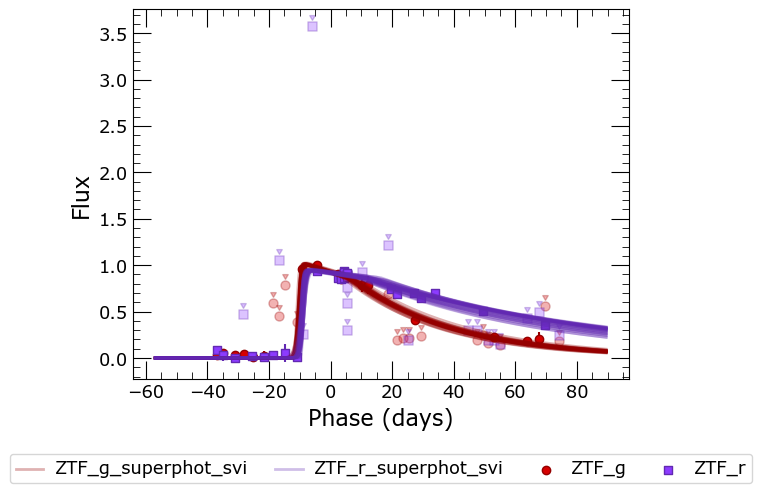

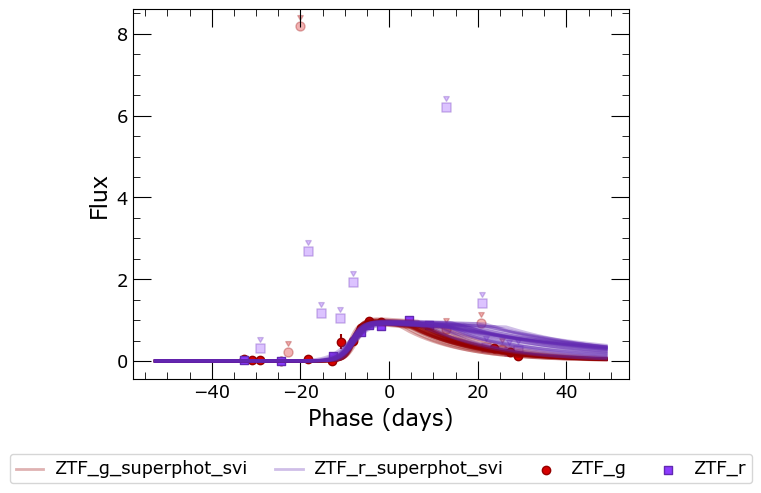

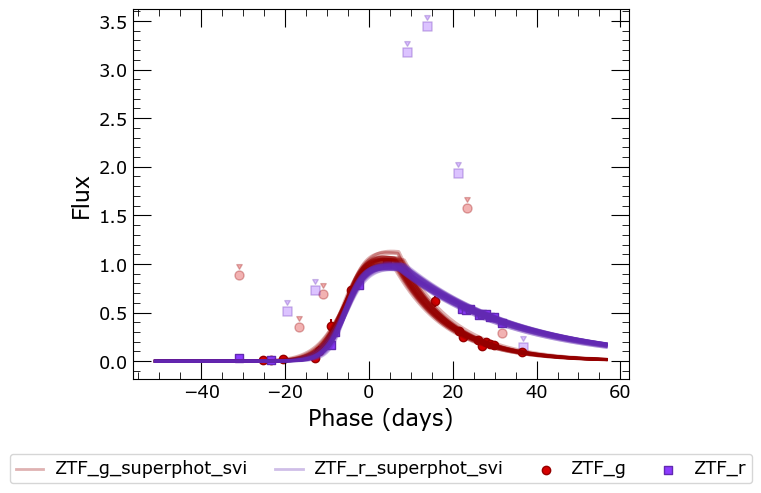

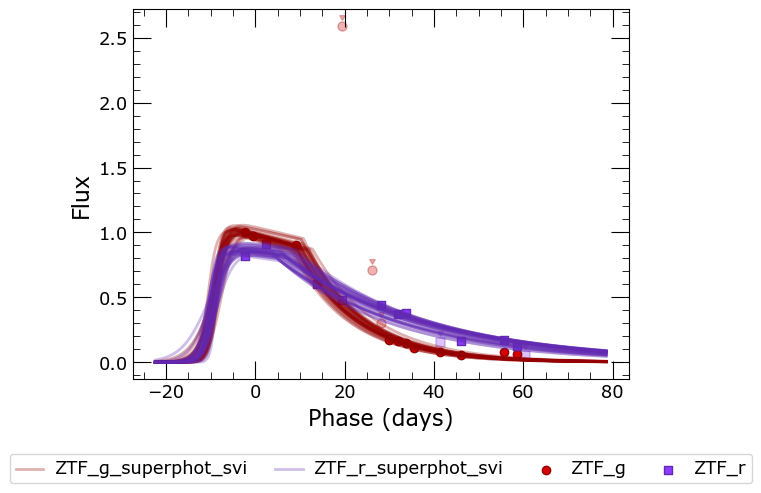

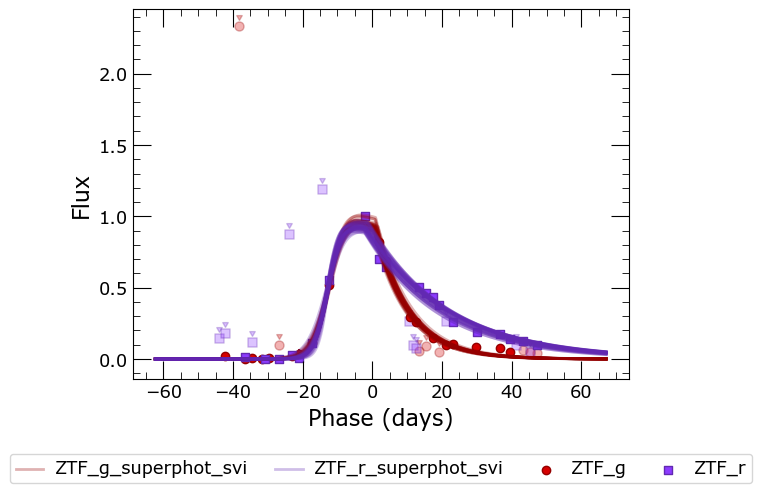

In [10]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

print(len(sampler_results), sampler_results.metadata.tail())
names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]:
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2 (Option 2): Fit light curves using dynesty (slower)

Here, we fit our transient photometry using the dynesty nested sampler. This is slower but does not assume Gaussianity of the posterior space, so can better capture degeneracies between parameters. If you use this, make sure to set sampler=superphot_dynesty in the config.yaml file.

Runtime for 7202 TNS samples: ~200 minutes (3.5 hours)

In [ ]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors, SuperphotPrior
from superphot_plus.config import SuperphotConfig

from pathlib import Path
import os

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")

config = SuperphotConfig.from_file("config.yaml")

#priors = generate_priors(["ZTF_r","ZTF_g"])
priors = SuperphotPrior.load(SAVE_DIR + "/" + "global_priors_hier_svi")

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

priors = generate_priors(["ZTF_r","ZTF_g"])

dynesty_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

result = fit_transient_group(
    transient_group,
    sampler = dynesty_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 128,
    pad=False,
    overwrite=True, # False to continue from checkpoint
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
)


In [ ]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])

svi_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]: # neweet 
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)

    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2.5: Convert SamplerResultGroup posteriors back to uncorrelated Gaussians

When sampling, the posteriors are saved as the inputs to our flux model. The Gaussian priors, however, were converted to log-Gaussians and multiplied by base parameters where necessary before being fed into the model function. Therefore, we must revert these log-Gaussian and relative parameters back to their original uncorrelated Gaussian draws before using as classifier inputs. We do this below:

In [11]:
# warning: only run once!
import os
from snapi import SamplerResultGroup
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

new_sr = []
for i, sr in enumerate(sampler_results):
    if i % 1000 == 0:
        print(f"Converted {i} out of {len(sampler_results)} fits")
    sr.fit_parameters = priors.reverse_transform(sr.fit_parameters)
    new_sr.append(sr)
    
new_sampler_results = SamplerResultGroup(new_sr)
new_sampler_results.save(config.sampler_results_fn)


Converted 0 out of 7341 fits
Converted 1000 out of 7341 fits
Converted 2000 out of 7341 fits
Converted 3000 out of 7341 fits
Converted 4000 out of 7341 fits
Converted 5000 out of 7341 fits
Converted 6000 out of 7341 fits
Converted 7000 out of 7341 fits


In [12]:
from snapi import SamplerResultGroup
from superphot_plus.config import SuperphotConfig
import os

config = SuperphotConfig.from_file("config.yaml")
srg = SamplerResultGroup.load(config.sampler_results_fn)
metadata = srg.metadata
metadata.to_csv(os.path.join(config.data_dir, "all_samples.csv"))
print(metadata.head())

          A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                                
2019J          -0.038573           0.005426            1.367325   
2019aafe       -0.049567           0.005790            0.938997   
2019aamp       -0.024724           0.005336            1.354411   
2019aanx        0.014167           0.004023            1.549233   
2019aaot        0.067342           0.003605            1.767469   

          t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                         
2019J           -15.684187               0.206188               1.596739   
2019aafe         -5.488179               0.277354               1.610640   
2019aamp        -17.224041               0.703987               1.666736   
2019aanx        -30.238449               0.746675               1.815376   
2019aaot        -34.405411               1.424315               2.118349  

## Step 3: Train + evaluate classifier from sampling posteriors

Here we train a classifier with our uncorrelated posterior features. This script will automatically split the data into K-folds, oversample the training and validation sets to even out minority classes, and train either LightGBMs (recommended) or MLPs. If plot is True, metric plots and confusion matrices will also be generated.

In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer
import pandas as pd
import os

config = SuperphotConfig.from_file("config.yaml")

# remove A_ZTF_r and t_0_ZTF_r from params used in classification - see paper for details
metadata = pd.read_csv(os.path.join(config.data_dir, "all_samples.csv"), index_col = 0)
keep_cols = metadata.drop(
    columns=['A_ZTF_r_median', 't_0_ZTF_r_median', 'score_median', 'sampler']
).columns
config.input_features = [c.replace("_median", "") for c in keep_cols]
print(config.input_features)

# train classifier
trainer = SuperphotTrainer(config)
trainer.run()

Finally, we train a version of the classifier without a test set (aka we use the entire dataset in training or validation). This is what we'll be using to classify a new, disparate dataset.

In addition to the classic full-phase classifier, we train a classifier that only uses early-phase features (excludes plateau durations and fall timescales). This is more effective at classifying partial supernova light curves.

In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer
from snapi import TransientGroup, SamplerResultGroup

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)
train_df, val_df = trainer.split(meta_df, split_frac=0.1)
train_srg = srg.filter(train_df.index)
val_srg = srg.filter(val_df.index)

trainer.train(0, (train_df, train_srg), (val_df, val_srg))
trainer.models[0].save(config.model_prefix + "_full")

# train early-type
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "t_0_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]

trainer.train(1, (train_df, train_srg), (val_df, val_srg))
trainer.models[1].save(config.model_prefix + "_early")

In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer, SuperphotLightGBM, SuperphotMLP
from snapi import TransientGroup, SamplerResultGroup

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)

# Comment as necessary to get the wanted model.
#trainer.models[0] = SuperphotLightGBM.load(config.model_prefix + "_full.pt")
trainer.models[0] = SuperphotMLP.load(config.model_prefix + "_full.pt")
#print(trainer.models[0].best_model.feature_name_)
#trainer.models[1]= SuperphotLightGBM.load(config.model_prefix + "_early.pt")
trainer.models[1]= SuperphotMLP.load(config.model_prefix + "_early.pt")
probs_avg = trainer.evaluate(0, (meta_df, srg))
probs_avg.to_csv(config.probs_fn[:-4] + "_full.csv")

# train early-type
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "t_0_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]

probs_avg_early = trainer.evaluate(1, (meta_df, srg))
probs_avg_early.to_csv(config.probs_fn[:-4] + "_early.csv")

In [ ]:
probs_avg_early

In [ ]:
probs_avg